In [11]:
import cotengra as ctg
import opt_einsum as oe
import math, torch, time
from BoundaryMPS import URand, BoundaryMPS
from copy import deepcopy
import numpy as np

In [12]:
def id_mapping(i, j, L):
    return i * L + j

def neigh_edge_2d(i, j, L):
    return [
        (id_mapping(i-1, j, L), id_mapping(i, j, L)), 
        (id_mapping(i, j-1, L), id_mapping(i, j, L)),
        (id_mapping(i, j, L), id_mapping(i+1, j, L)),
        (id_mapping(i, j, L), id_mapping(i, j+1, L)),
    ]

In [13]:
torch.set_num_threads(1)
n, bond_dim, lam, seed = 16, 2, -0.5, 0
L = n
n = n ** 2
device = 'cpu'
urand = URand(L, bond_dim, lam, seed)
tn = urand.construct_tn()

edges = []
for i in range(L):
    for j in range(L):
        if j < L-1:
            edges.append((i*L+j, i*L+j+1))
        if i >= 1:
            edges.append(((i-1)*L+j, i*L+j))

eq_sep = [
    ''.join([oe.get_symbol(edges.index(nei_edge)) for nei_edge in neigh_edge_2d(i, j, L) if nei_edge in edges]) for i in range(L) for j in range(L)
]
eq = ','.join(eq_sep) + '->'
shapes = [(4,)*len(e) for e in eq_sep]
bonds = set().union(*[list(e) for e in eq_sep])
size_dict = {bond: bond_dim for bond in bonds}

tn_reshape = sum(tn, start=[])
for i in range(len(tn_reshape)):
    if 1 in list(tn_reshape[i].shape):
        tn_reshape[i] = tn_reshape[i].reshape([s for s in list(tn_reshape[i].shape) if s == bond_dim])
    assert len(tn_reshape[i].shape) == len(eq_sep[i])
    tn_reshape[i] = tn_reshape[i].to(device)
    
# cotengra result
opt = ctg.HyperOptimizer(
    max_repeats=64, parallel=16, 
    slicing_reconf_opts={'target_size':2**31},
    progbar=False
)
tree = opt.search(eq_sep, (), size_dict)

result_exact = tree.contract(deepcopy(tn_reshape), progbar=False, strip_exponent=True)# oe.contract(eq, *tn_reshape, optimize=path)
result_exact = (result_exact[0].cpu(), result_exact[1].cpu())
lnZ_exact = result_exact[0].item() * 10 ** result_exact[1].item()
print(lnZ_exact)

data = [[], []]
for chi in [4, 6, 8, 12, 16, 24, 32, 48, 64, 96, 128]:
    bmps = BoundaryMPS(torch)
    t0 = time.time()
    result, error = bmps(deepcopy(tn), 'normal', chi, 0.0)
    lnZ = result[0] * 10 ** result[1]
    tt = time.time() - t0

    t0 = time.time()
    result3, error3 = bmps(deepcopy(tn), 'three', chi, 0.0)
    lnZ3 = result3[0] * 10 ** result3[1]
    t3 = time.time() - t0

    # t0 = time.time()
    # result4, error4 = bmps(deepcopy(tn), 'four', chi, 0.0)
    # lnZ4 = result4[0] * 10 ** result4[1]
    # t4 = time.time() - t0
    # print(result[0].item(), result3[0].item(), result4[0].item())
    # print(lnZ.item(), lnZ3.item(), lnZ4.item())

    error = abs(1-result[0]/result_exact[0]*10**(result[1]-result_exact[1])).item()
    error3 = abs(1-result3[0]/result_exact[0]*10**(result3[1]-result_exact[1])).item()
    # error4 = abs(1-result4[0]/result_exact[0]*10**(result4[1]-result_exact[1])).item()
    print(f'normal boundary mps, chi {chi}, time {tt:.3g}, Z error {error:.5g}')
    print(f'threeway boundary mps, chi {chi}, time {t3:.3g}, Z error {error3:.5g}')
    # print(f'fourway boundary mps, chi {chi}, time {t4:.3g}, Z error {error4:.5g}')
    data[0].append((tt, error))
    data[1].append((t3, error3))

2.376660756196172e-06
normal boundary mps, chi 4, time 0.0776, Z error 0.37053
threeway boundary mps, chi 4, time 0.083, Z error 0.15169
normal boundary mps, chi 6, time 0.0843, Z error 0.052052
threeway boundary mps, chi 6, time 0.0921, Z error 0.036053
normal boundary mps, chi 8, time 0.0792, Z error 0.073095
threeway boundary mps, chi 8, time 0.0954, Z error 0.18517
normal boundary mps, chi 12, time 0.0753, Z error 0.0099814
threeway boundary mps, chi 12, time 0.0927, Z error 0.0015531
normal boundary mps, chi 16, time 0.0749, Z error 0.0028312
threeway boundary mps, chi 16, time 0.109, Z error 0.0038068
normal boundary mps, chi 24, time 0.0946, Z error 0.00030555
threeway boundary mps, chi 24, time 0.141, Z error 0.00016384
normal boundary mps, chi 32, time 0.104, Z error 8.0379e-07
threeway boundary mps, chi 32, time 0.199, Z error 9.6676e-07
normal boundary mps, chi 48, time 0.138, Z error 3.4403e-07
threeway boundary mps, chi 48, time 0.311, Z error 2.5086e-08
normal boundary mp

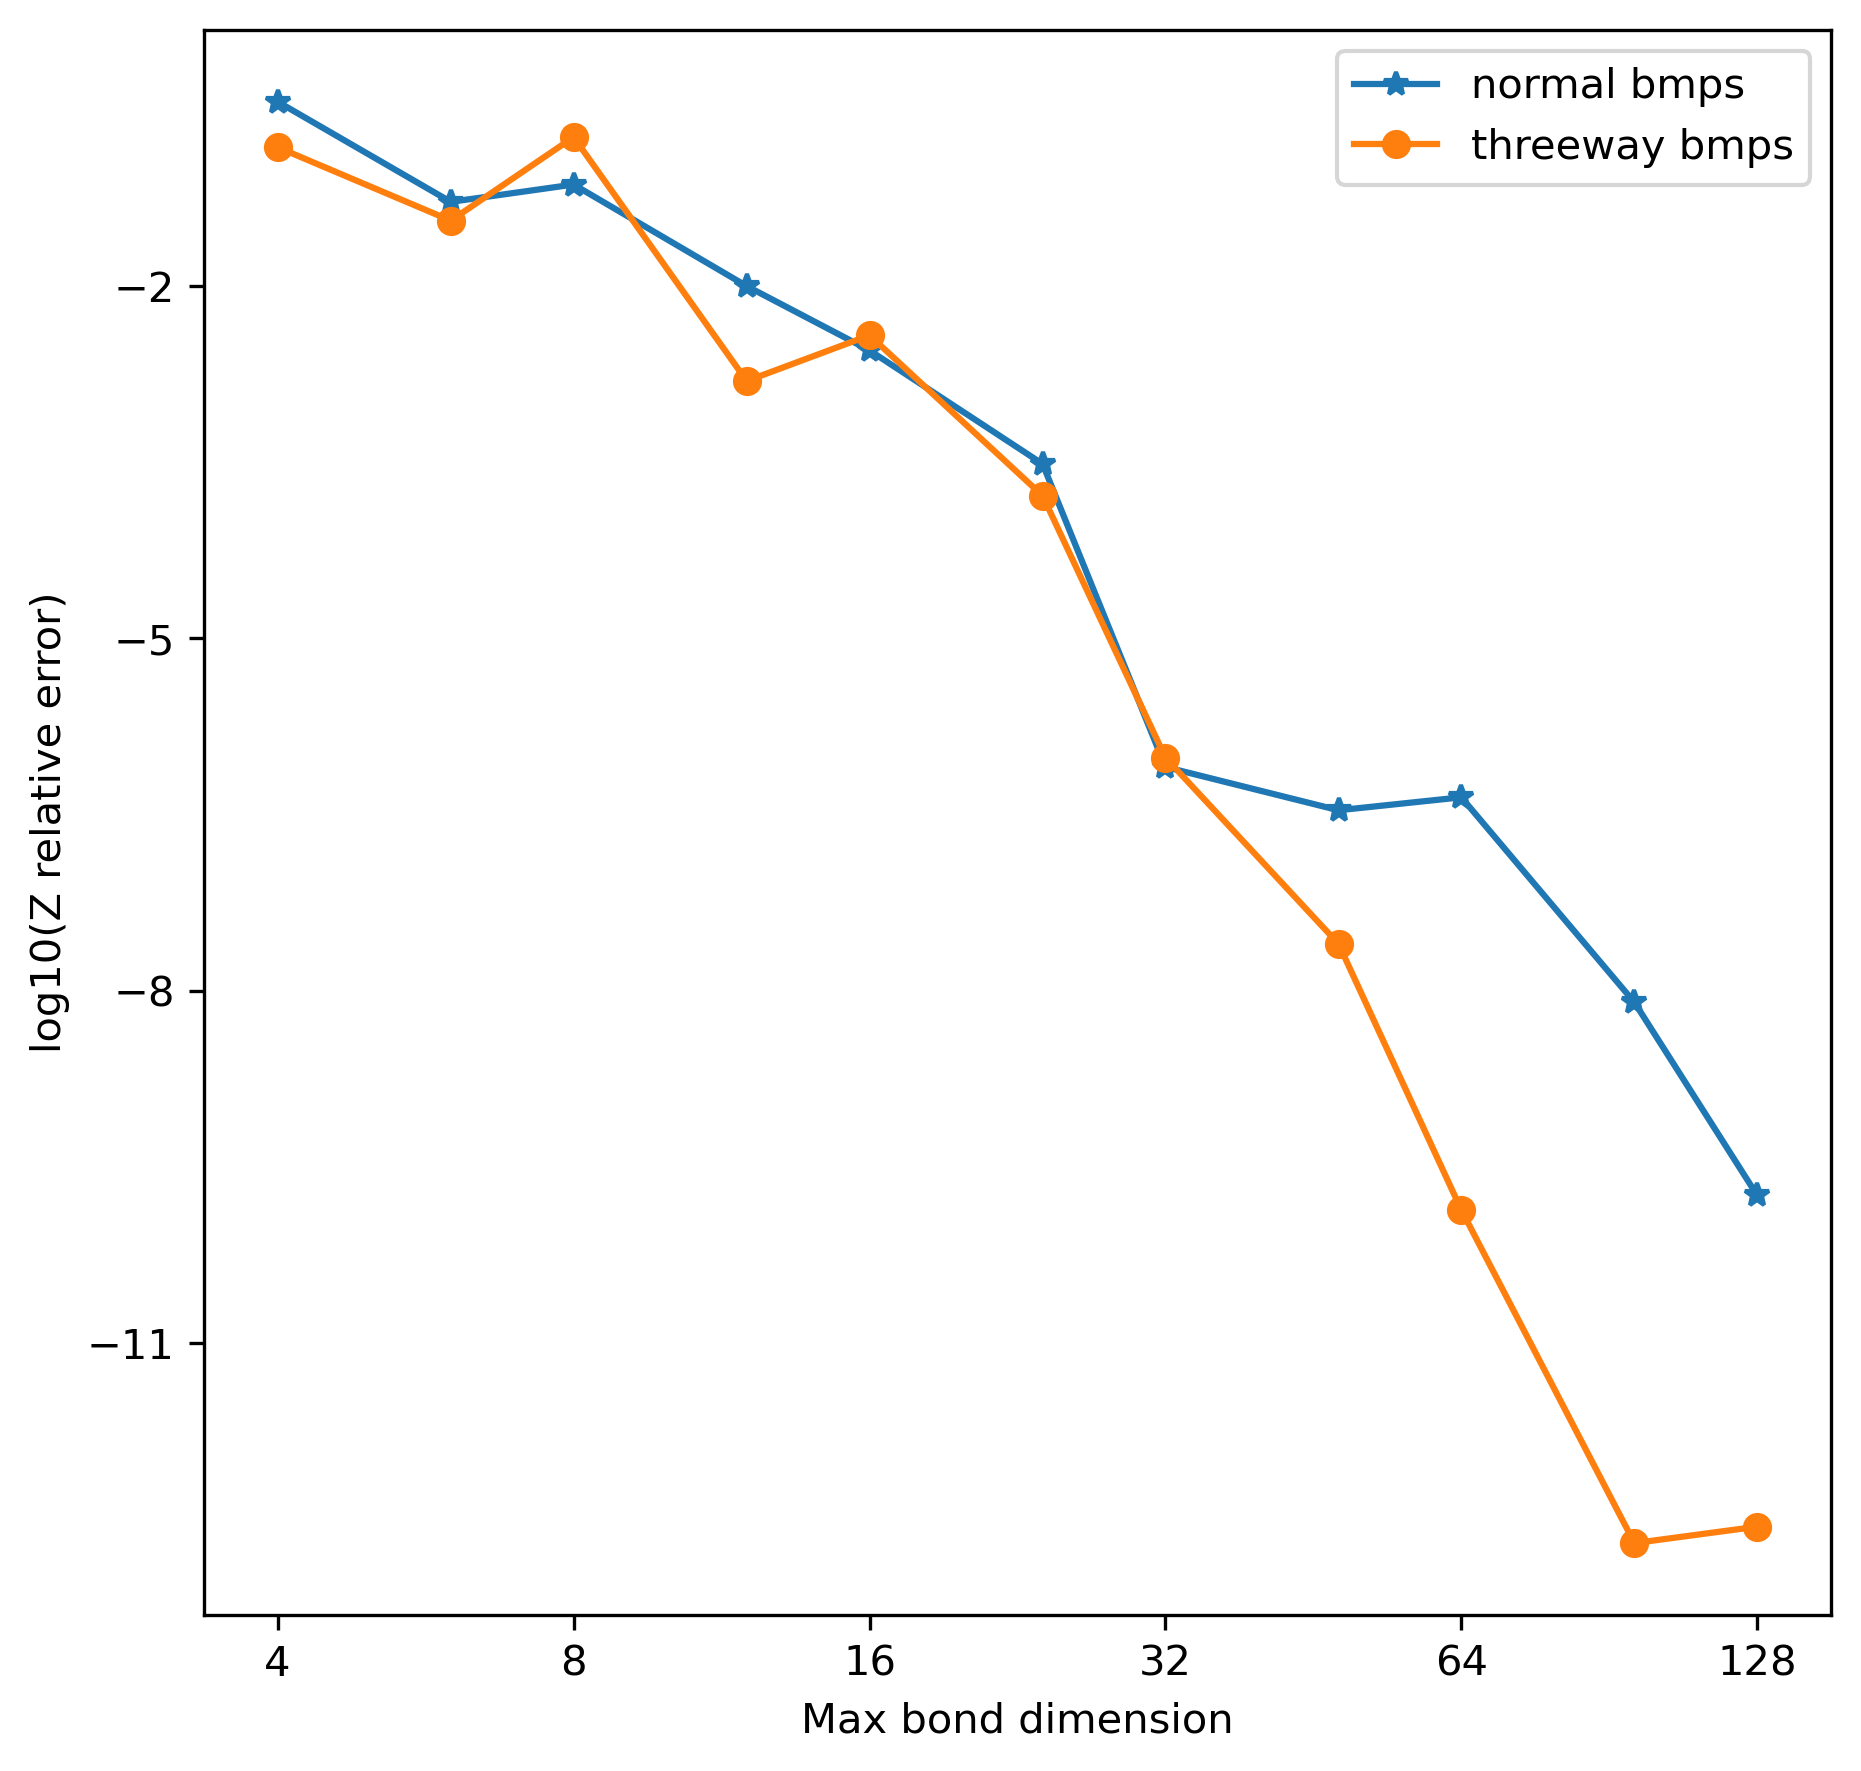

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
chi = [4, 6, 8, 12, 16, 24, 32, 48, 64, 96, 128]
normal_time = [np.mean([data[i][j][0] for i in range(0, len(data), 2)]) for j in range(len(chi))]
threeway_time = [np.mean([data[i][j][0] for i in range(1, len(data), 2)]) for j in range(len(chi))]
normal_error = [np.mean(np.log10([data[i][j][1] for i in range(0, len(data), 2)])) for j in range(len(chi))]
threeway_error = [np.mean(np.log10([data[i][j][1] for i in range(1, len(data), 2)])) for j in range(len(chi))]
plt.figure(figsize=(7, 7), dpi=300)
plt.plot(np.log2(chi), normal_error, marker='*', label='normal bmps')
plt.plot(np.log2(chi), threeway_error, marker='o', label='threeway bmps')
plt.xticks([2, 3, 4, 5, 6, 7], [4, 8, 16, 32, 64, 128])
plt.yticks([-2, -5, -8, -11])
plt.xlabel('Max bond dimension')
plt.ylabel('log10(Z relative error)')
plt.legend()